In [1]:
import pandas as pd

# Import data and run model

In [2]:
id_vars = ['subject_id','hadm_id','icustay_id']

In [3]:
static = pd.read_csv('static.csv').set_index(id_vars)

In [4]:
static.reset_index().subject_id.nunique()

33629

In [5]:
X= pd.read_csv('X3').set_index(id_vars+['hours_in'])

In [6]:
X.drop('level_3',axis=1,inplace=True)

In [7]:
cols_to_add = ['past_admissions',
       'past_admissions_icu', 'prev_surgeries', 'prev_surgeries_mv']

X = X.join(static[cols_to_add])

X['hours_since_ad']=X.index.get_level_values('hours_in')

In [8]:
Y= pd.read_csv('Y3').set_index(id_vars+['hours_in'])

In [9]:
Y = Y[~pd.isnull(X.iloc[:,0])]

X = X[~pd.isnull(X.iloc[:,0])]

In [11]:
Y.shape,X.shape

((57764, 1), (57764, 362))

In [12]:
Y = Y[X.hours_since_ad>12]

In [13]:
X = X[X.hours_since_ad>12]

In [14]:
Y.shape,Y.reset_index().subject_id.nunique(),Y.sum(),Y[Y["0"]==1].reset_index().subject_id.nunique()

((48701, 1), 12442, 0    370
 dtype: int64, 177)

In [15]:
static['intervention']=static.join(Y).reset_index().groupby(id_vars)['0'].max().fillna(0)

In [16]:
Y_for_split = Y.reset_index().groupby(['subject_id'])['0'].max().reset_index()

In [17]:
from sklearn.model_selection import train_test_split
def train_test_val(Y_for_split,random_seed=42):
    train_ids, rest_ids = train_test_split(Y_for_split, test_size=0.25,
                                           random_state=random_seed,
                                           stratify=Y_for_split['0'])
    test_ids, val_ids = train_test_split(rest_ids, test_size=0.5,
                                                random_state=random_seed,
                                         stratify=rest_ids['0'])

    return train_ids, val_ids, test_ids
def tvt_split(x,y,train_ids, val_ids, test_ids):
    x_train = x[x.index.get_level_values('subject_id').isin(train_ids['subject_id'])]
    x_val = x[x.index.get_level_values('subject_id').isin(val_ids['subject_id'])]
    x_test = x[x.index.get_level_values('subject_id').isin(test_ids['subject_id'])]
    y_train = y[y.index.get_level_values('subject_id').isin(train_ids['subject_id'])]
    y_val = y[y.index.get_level_values('subject_id').isin(val_ids['subject_id'])]
    y_test = y[y.index.get_level_values('subject_id').isin(test_ids['subject_id'])]
    return x_train,x_val,x_test,y_train,y_val,y_test



In [18]:
from xgboost import XGBClassifier
def training_testing(x_train, x_val, x_test, y_train, y_val, y_test,
                     hyp_search = False, grid_search=False, do_adapt=0,n_trials=5):
    XGB_hyperparams_list = {
        'eval_metric': 'auc',
        'learning_rate': 0.06980199434376165,
         'n_estimators': 505,
         'max_depth': 3,
         'scale_pos_weight': 2544.43352201207,
         'min_child_weight': 2,
         'gamma': 0.0015018451272972237}
    model_name, model, hyperparams_list = ('XGB', XGBClassifier, XGB_hyperparams_list)
    print('Initial test, with hardcoded hyperparameters')
    M = model(**hyperparams_list)
    M.fit(x_train, y_train)
    y_pred = pd.DataFrame(M.predict_proba(x_test))
    Y_test = pd.DataFrame(y_test)

    from sklearn.metrics import roc_auc_score
    test_score = roc_auc_score(Y_test, y_pred.iloc[:, 1])
    print(test_score)
    return M, M.feature_importances_, Y_test, y_pred,test_score


In [19]:
train_ids, val_ids, test_ids = train_test_val(Y_for_split, random_seed=42)
x_train, x_val, x_test, y_train, y_val, y_test = tvt_split(X, Y, train_ids, val_ids, test_ids)
model, feature_impo, test, pred, test_score = training_testing(x_train, x_val, x_test, y_train.values.ravel(),
                                                               y_val.values.ravel(), y_test.values.ravel(),
                                                               grid_search=False, hyp_search=False)


Initial test, with hardcoded hyperparameters
0.7250278323897956


In [20]:
df_stats = pd.concat([y_train['0'].value_counts(),y_test['0'].value_counts()],axis=1)
df_stats.columns=['train','test']
df_stats.index = ['clean','postive']
df_stats

,train,test
clean,36009,6031
postive,275,42


# Run shap explainer

In [21]:
import shap
explainer = shap.TreeExplainer(model)


In [22]:
shap_values2 = explainer(x_train)


In [23]:
shap_full = abs(shap_values2.values).mean(axis=0)

In [24]:
df = pd.DataFrame({'fi':feature_impo,'shap':shap_full})
df.index = X.columns

# organize by category and feature

In [25]:
def make_cat(x,a_list):
    for i in a_list:
        if i == x.split(" ")[-1]:
            return i
a_list = ['mean','mask','time_since_measured']
col_categories = []
for col in X.columns.values:
    col_categories.append(make_cat(col,a_list))
df['category']=col_categories

In [26]:
df.fillna(0).groupby('category').sum()

,fi,shap
category,,
0,0.016980,0.760930
mask,0.102721,0.250562
mean,0.402441,4.596318
time_since_measured,0.477859,7.378749


In [27]:
def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

s = "mean blood pressure mean"
rreplace(s,'mean',"",1)

vars_list = []
for n,i in enumerate(df.index.values):
    if pd.isnull(df['category'][n]):
        vars_list.append(i)
    else:
        vars_list.append(rreplace(i,df['category'][n],"",1))

df['variable']=vars_list

# Top 10 features

In [28]:
df2 = df.groupby('variable').sum()

In [29]:
df2.sort_values('fi')[-10:]

,fi,shap
variable,,
magnesium,0.021217,0.036873
lymphocytes ascites,0.021621,0.134174
urine output,0.025046,0.127918
central venous pressure,0.026764,0.177299
respiratory rate,0.027543,0.035109
phosphorous,0.028591,0.046095
asparate aminotransferase,0.029585,0.007440
partial pressure of carbon dioxide,0.031665,0.205408
glascow coma scale verbal response,0.032102,0.249184


In [30]:
df2.sort_values('shap')[-10:]

,fi,shap
variable,,
lactate dehydrogenase,0.005119,0.242187
glascow coma scale verbal response,0.032102,0.249184
pulmonary artery pressure systolic,0.015284,0.250516
cpk,0.006908,0.271915
pulmonary capillary wedge pressure,0.015802,0.299327
mean airway pressure,0.011655,0.316249
rass,0.013788,0.340868
total protein urine,0.009831,0.347376
red blood cell count pleural,0.008842,0.354947


In [31]:
df2.sort_values('fi').to_csv('feature_importance.csv')

# Top 10 sub-features

In [32]:
df.sort_values('fi')[-10:]

,fi,shap,category,variable
bilirubin mean,0.017173,0.151795,mean,bilirubin
urine output mean,0.018952,0.104082,mean,urine output
lymphocytes ascites mean,0.019405,0.008305,mean,lymphocytes ascites
magnesium time_since_measured,0.019775,0.007362,time_since_measured,magnesium
oxygen saturation time_since_measured,0.020517,0.015661,time_since_measured,oxygen saturation
central venous pressure mean,0.020576,0.064056,mean,central venous pressure
phosphorous time_since_measured,0.021877,0.006524,time_since_measured,phosphorous
glascow coma scale verbal response time_since_measured,0.023398,0.011220,time_since_measured,glascow coma scale verbal response
respiratory rate mask,0.026534,0.011127,mask,respiratory rate
asparate aminotransferase time_since_measured,0.029578,0.007266,time_since_measured,asparate aminotransferase


In [33]:
df.sort_values('shap')[-10:]

,fi,shap,category,variable
rass time_since_measured,0.004333,0.212088,time_since_measured,rass
prev_surgeries,0.003646,0.224750,None,prev_surgeries
creatinine body fluid time_since_measured,0.005224,0.226513,time_since_measured,creatinine body fluid
plateau pressure mean,0.006332,0.227808,mean,plateau pressure
glascow coma scale verbal response mean,0.008703,0.237964,mean,glascow coma scale verbal response
mean airway pressure time_since_measured,0.005722,0.278090,time_since_measured,mean airway pressure
pulmonary capillary wedge pressure time_since_measured,0.015802,0.299327,time_since_measured,pulmonary capillary wedge pressure
total protein urine time_since_measured,0.006015,0.334596,time_since_measured,total protein urine
red blood cell count pleural time_since_measured,0.005355,0.335445,time_since_measured,red blood cell count pleural
hours_since_ad,0.005778,0.367009,None,hours_since_ad


In [35]:
from sklearn.metrics import confusion_matrix,roc_curve

In [36]:
predictions = model.predict(x_test)

In [37]:
confusion_matrix(y_test,predictions)

array([[5626,  405],
       [  35,    7]], dtype=int64)

In [39]:
fpr, tpr, _  = roc_curve(y_test,pred.loc[:,1],)

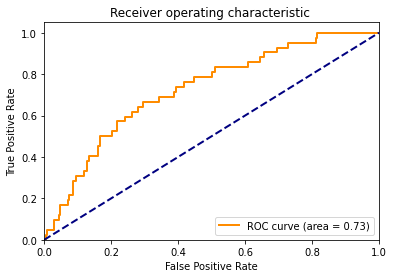

In [40]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % test_score,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()